In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [4]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib import cm
import numpy as np


from osse import *
nancol = (0.65,0.65,0.65)

In [5]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon/input/"

In [6]:
ds = xr.open_dataset(data_dir+"geocoords_original.nc")
newds = xr.open_dataset(data_dir+"geocoords.nc")

In [7]:
min_elv = newds.attrs['min_elv']
Hz = newds.attrs['Hz']
dz0 = newds.attrs['dz0']

Hbot = newds['z'] - min_elv - (Hz - dz0)

Hremoved = newds['z_slope'] + min_elv
Hoffset = Hremoved + (Hz-dz0)

In [8]:
lon1 = -18.3; lon2 = lon1; lon3 = lon1; 
lat1 = -21.7; lat2 = lat1; lat3 = lat1;

In [9]:
x = newds['Xr'].values[:]
z = newds['Z'].values[:]

sec_j = newds['Yr'].size//2-4


# Moorings
geo = xr.open_dataset(data_dir+"geocoords.nc").drop(["X", "Y"])
moorings = {
    #"CTS17-P1": {'coords': (-14.58, -21.12)},
    "CTS17-P2": {'coords': (-14.59, -21.10)},
    "T05": {'coords': (-17.-48.5/60., -21.-36.9/60.)}
}

lons = [mooring['coords'][0] for mooring in moorings.values()]
lats = [mooring['coords'][1] for mooring in moorings.values()]
markers = ['v', 's']#['o', 'v', 's']
samples = sample_locations(geo, lons, lats)

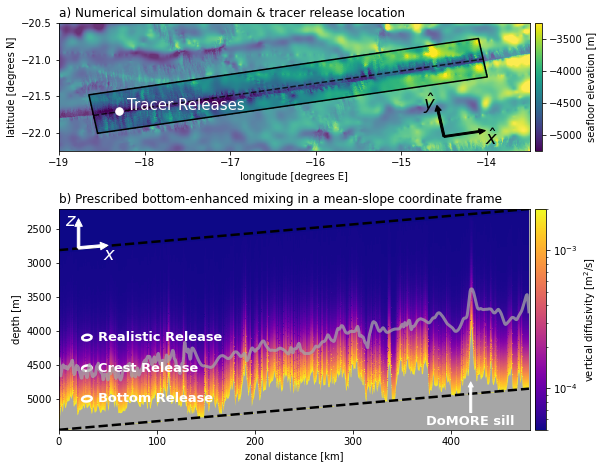

In [23]:

scale_fig = 0.55
fig = plt.figure(figsize=(16*scale_fig,12*scale_fig))
gs = fig.add_gridspec(5, 1)

### XY
f_ax1 = fig.add_subplot(gs[:2, :])

clims = [-5250, -3250]
q = ds['z'].plot.pcolormesh(x='lon', y='lat')
plt.fill_between([-25, -10], [-30, -30], [0, 0], facecolor="w", alpha=0.20)
q.set_rasterized(True)
q.set_clim(clims)
q.colorbar.remove()
q = (newds['z_actual']).plot(x='lon', y='lat')
q.set_clim(clims)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, label=r"seafloor elevation [m]")
plt.plot([newds['lon'].isel(Xr=0, Yr=sec_j), newds['lon'].isel(Xr=-1, Yr=sec_j)], [newds['lat'].isel(Xr=0, Yr=sec_j), newds['lat'].isel(Xr=-1, Yr=sec_j)], "k--", alpha=0.75)

plt.plot(lon1, lat1, "wo", markersize=7.5)
plt.annotate(s="Tracer Releases", xy=(lon1+0.095, lat1+0.0725), horizontalalignment="left", verticalalignment="center", fontsize=15, color="w")

plt.plot(
    [newds['lon'].isel(Xr=0, Yr=0), newds['lon'].isel(Xr=0, Yr=-1), newds['lon'].isel(Xr=-1, Yr=-1), newds['lon'].isel(Xr=-1, Yr=0), newds['lon'].isel(Xr=0, Yr=0)],
    [newds['lat'].isel(Xr=0, Yr=0), newds['lat'].isel(Xr=0, Yr=-1), newds['lat'].isel(Xr=-1, Yr=-1), newds['lat'].isel(Xr=-1, Yr=0), newds['lat'].isel(Xr=0, Yr=0)],
    "k-"
)

X0 = newds['lon'].isel(Xr=0, Yr=0);
Xx = newds['lon'].isel(Xr=-1, Yr=0);
Xy = newds['lon'].isel(Xr=0, Yr=-1);
Y0 = newds['lat'].isel(Xr=0, Yr=0);
Yx = newds['lat'].isel(Xr=-1, Yr=0);
Yy = newds['lat'].isel(Xr=0, Yr=-1)
Xa = -14.5; Ya = -22.05;
plt.arrow(Xa, Ya, (Xx-X0)*0.09, (Yx-Y0)*0.09, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.arrow(Xa, Ya, (Xy-X0)*0.67, (Yy-Y0)*0.67, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.annotate(s=r"$\hat{x}$", xy=(Xa+0.48, Ya-0.12), fontsize=18)
plt.annotate(s=r"$\hat{y}$", xy=(Xa-0.25, Ya+0.365), fontsize=18)
plt.title("")
plt.xlabel("longitude [degrees E]")
plt.ylabel("latitude [degrees N]")
plt.xticks(np.arange(-19, -13, 1))
plt.yticks(np.arange(-22.5, -20, 0.5))

plt.ylim([-22.25, -20.5])
plt.xlim([-19, -13.5])

plt.title("a) Numerical simulation domain & tracer release location", loc='left')

### XZ
f_ax1 = fig.add_subplot(gs[2:, :], facecolor=nancol)
q = plt.pcolor(x[np.newaxis,:]*1e-3, z[:,np.newaxis]+Hoffset.values,newds['K'][:,sec_j,:].values, norm=matplotlib.colors.LogNorm(vmin=5.e-5, vmax=2.e-3), cmap="plasma")
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar(q, pad=0.01, label=r"vertical diffusivity [m$^{2}$/s]")
plt.fill_between(x*1e-3, Hremoved - 10, Hbot[sec_j,:]+Hoffset, facecolor=nancol)
plt.fill_between(x*1e-3, Hremoved + (Hz-50.), np.zeros_like(x), facecolor=cm.plasma(0.))

plt.plot(x*1e-3, Hremoved, "k--", lw=2.5)
plt.plot(x*1e-3, Hremoved+(Hz-dz0), "k--", lw=2.5)
plt.plot(Hbot['Xr']*1e-3, (Hbot+Hoffset).isel(Yr=np.append(np.arange(-10,0), np.arange(0,10))).mean(dim='Yr'), color=nancol, lw=3.0, alpha=0.75)

plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['BBTRE'].values[:,newds['Yr'].size//2,:], levels=[0.37], colors="w", linewidths=2.5)
plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['Crest'].values[:,newds['Yr'].size//2,:], levels=[0.37], colors="w", linewidths=2.5)
plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['Bottom'].values[:,newds['Yr'].size//2,:], levels=[0.37], colors="w", linewidths=2.5)


plt.annotate(s="Realistic Release", xy=(40, -4150), color="w", fontsize=13, weight="bold")
plt.annotate(s="Crest Release", xy=(40, -4600), color="w", fontsize=13, weight="bold")
plt.annotate(s="Bottom Release", xy=(40, -5050), color="w", fontsize=13, weight="bold")
plt.annotate(
    s="DoMORE sill", xytext=(420, -5325), xy=(420, -4750), color="w", fontsize=13, weight="bold",
    va="center", ha="center",
    arrowprops=dict(headlength=5, width=2, headwidth=5, color='w')
)

plt.yticks(np.arange(-5000, -2000, 500), np.arange(5000, 2000, -500))

plt.xlim([0, 600.*newds['Xr'].size*1e-3])
plt.ylim([Hremoved.min(), (Hremoved + (Hz-dz0)).max()])

θ = 0.0012618506382207175
X0 = 20e3; Z0 = -2780;
Mag = 30e3;
arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='w')
X1 = X0 + Mag*np.cos(θ); Z1 = Z0 + Mag*np.sin(θ)
plt.annotate("", (X1*1e-3, Z1), (X0*1e-3, Z0), arrowprops=arrowprops, xycoords="data")
scale = 1/70.
X2 = X0 - Mag*np.sin(θ)*scale; Z2 = Z0 + Mag*np.cos(θ)*scale
plt.annotate("", (X2*1e-3, Z2), (X0*1e-3, Z0), arrowprops=arrowprops, xycoords="data")
plt.annotate(s=r"$z$", xy=(X0*1e-3-14, Z0+325), fontsize=18, color="w")
plt.annotate(s=r"$x$", xy=(X0*1e-3+25, Z0-180), fontsize=18, color="w")
plt.title("b) Prescribed bottom-enhanced mixing in a mean-slope coordinate frame", loc='left')

plt.tight_layout()
plt.savefig(f"../../figures/BBTRE-tracer/domain_configuration.png", dpi=250., bbox_inches='tight')